In [5]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Set seaborn style
sns.set_theme(style="whitegrid")  # This is safer than plt.style.use('seaborn')
sns.set_palette("husl")

In [6]:
def generate_synthetic_data(n_samples=5000):
    # Generate features for each segment
    def generate_segment(n, watch_mean, completion_mean, rating_mean):
        return np.column_stack((
            np.random.normal(watch_mean, 15, n),  # watch_time
            np.random.normal(completion_mean, 0.1, n).clip(0, 1),  # completion_rate
            np.random.normal(rating_mean, 0.5, n).clip(1, 5)  # rating
        ))
    
    # Generate data for each segment
    casual = generate_segment(n_samples//3, 60, 0.7, 3.0)
    regular = generate_segment(n_samples//3, 120, 0.85, 4.0)
    enthusiast = generate_segment(n_samples//3, 180, 0.95, 4.5)
    
    # Combine data and create labels
    X = np.vstack([casual, regular, enthusiast])
    y = np.array([0] * (n_samples//3) + [1] * (n_samples//3) + [2] * (n_samples//3))
    
    return X, y

# Generate data
X, y = generate_synthetic_data()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (3998, 3)
Test set shape: (1000, 3)


The algorithm creates three distinct user segments:

Casual Users:

Watch time: Mean of 60 (units, likely minutes) with 15 unit standard deviation
Completion rate: Mean of 0.7 (70%) with 0.1 standard deviation
Rating: Mean of 3.0 with 0.5 standard deviation

Regular Users:

Watch time: Mean of 120 minutes
Completion rate: Mean of 0.85 (85%)
Rating: Mean of 4.0

Enthusiast Users:

Watch time: Mean of 180 minutes
Completion rate: Mean of 0.95 (95%)
Rating: Mean of 4.5

Key aspects of the implementation:

The generate_segment helper function:


Uses np.random.normal to generate normally distributed values
Takes parameters for means of each feature
Generates data for all three features at once using np.column_stack
Uses .clip() to ensure realistic bounds:

Completion rates are clipped between 0 and 1
Ratings are clipped between 1 and 5


Data Distribution:

Creates equal-sized segments (n_samples//3 for each group)
Total sample size is 5000 by default
Each segment gets approximately 1,667 samples

Final Dataset Structure:

Features (X): Combined matrix of all segments (5000 × 3)
Labels (y): Array of labels (0, 1, 2) corresponding to each segment

Data Splitting:

Uses train_test_split with 80-20 ratio
Training set: 80% of data
Test set: 20% of data
Random state set to 42 for reproducibility

This synthetic data simulates a realistic scenario where:

Casual users watch less and have lower completion rates
Regular users show moderate engagement
Enthusiasts show high engagement across all metrics
Each metric has natural variation (standard deviation) to simulate real-world randomness

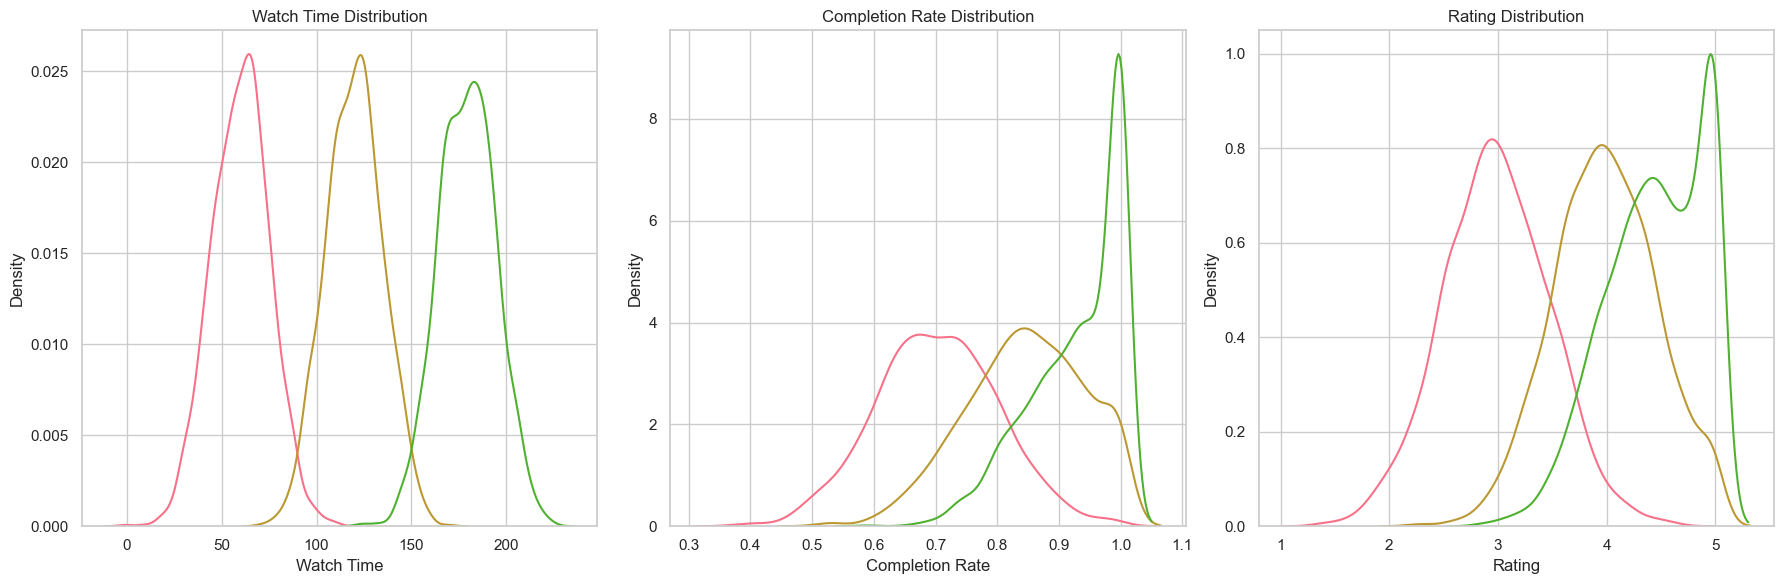

In [7]:
def plot_feature_distributions(X, y):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    features = ['Watch Time', 'Completion Rate', 'Rating']
    
    for i, (ax, feature) in enumerate(zip(axes, features)):
        for segment in [0, 1, 2]:
            sns.kdeplot(data=X[y == segment, i], ax=ax, label=f'Segment {segment}')
        ax.set_title(f'{feature} Distribution')
        ax.set_xlabel(feature)
        ax.set_ylabel('Density')
    
    plt.tight_layout()
    plt.show()

plot_feature_distributions(X, y)

In [8]:
# Initialize and train model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)
svm.fit(X_train_scaled, y_train)

# Make predictions
y_pred = svm.predict(X_test_scaled)

Model Performance Metrics:
Accuracy: 0.979
Precision: 0.979
Recall: 0.979
F1 Score: 0.979

Confusion Matrix:


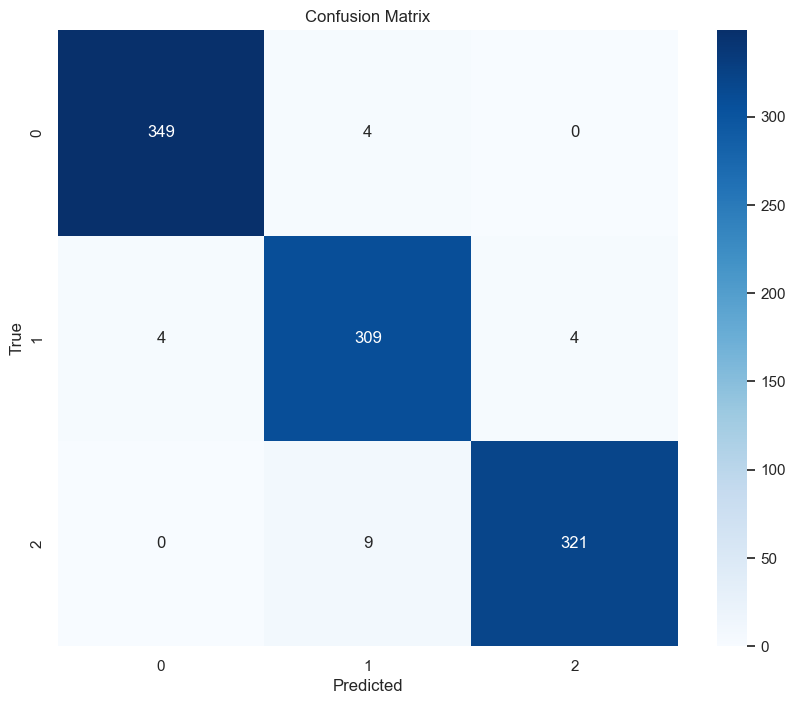

In [9]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def print_metrics(y_true, y_pred):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='weighted'),
        'Recall': recall_score(y_true, y_pred, average='weighted'),
        'F1 Score': f1_score(y_true, y_pred, average='weighted')
    }
    
    for metric, value in metrics.items():
        print(f"{metric}: {value:.3f}")

print("Model Performance Metrics:")
print_metrics(y_test, y_pred)
print("\nConfusion Matrix:")
plot_confusion_matrix(y_test, y_pred)

Performance Metrics:

Accuracy: 0.979 (97.9%)
Precision: 0.979
Recall: 0.979
F1 Score: 0.979

These consistently high scores around 97.9% indicate this is a very well-performing model.
The Confusion Matrix shown is a 3x3 matrix, which means this is a classification problem with 3 classes (labeled 0, 1, and 2). Let's interpret the matrix:

Reading the diagonal (correctly classified instances):


Class 0: 349 correct predictions
Class 1: 309 correct predictions
Class 2: 321 correct predictions


Misclassifications:


Class 0 was misclassified as Class 1 in 4 cases
Class 1 was misclassified as Class 0 in 4 cases and as Class 2 in 4 cases
Class 2 was misclassified as Class 1 in 9 cases

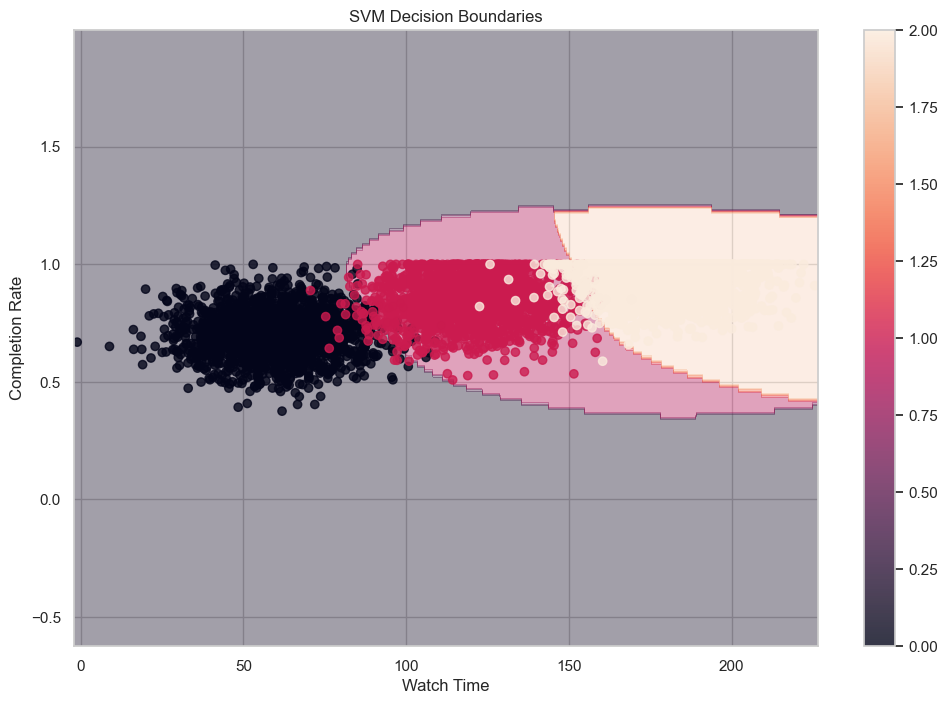

In [10]:
def plot_decision_boundaries(X, y, model, scaler):
    # Create mesh grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    # Get predictions for mesh grid points
    Z = model.predict(scaler.transform(np.c_[xx.ravel(), yy.ravel(), np.ones(xx.ravel().shape) * 3.5]))
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundaries
    plt.figure(figsize=(12, 8))
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)
    plt.xlabel('Watch Time')
    plt.ylabel('Completion Rate')
    plt.title('SVM Decision Boundaries')
    plt.colorbar()
    plt.show()

# Plot decision boundaries for first two features
plot_decision_boundaries(X, y, svm, scaler)

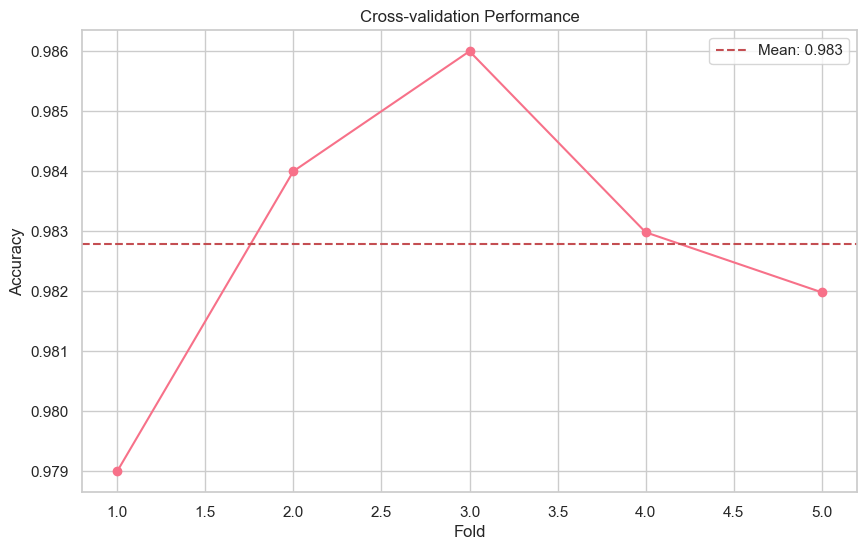

In [11]:
def plot_cross_validation_results():
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []
    
    for train_idx, val_idx in kf.split(X):
        X_train_cv, X_val_cv = X[train_idx], X[val_idx]
        y_train_cv, y_val_cv = y[train_idx], y[val_idx]
        
        # Scale and train
        scaler_cv = StandardScaler()
        X_train_cv_scaled = scaler_cv.fit_transform(X_train_cv)
        X_val_cv_scaled = scaler_cv.transform(X_val_cv)
        
        svm_cv = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
        svm_cv.fit(X_train_cv_scaled, y_train_cv)
        
        cv_scores.append(svm_cv.score(X_val_cv_scaled, y_val_cv))
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 6), cv_scores, marker='o')
    plt.axhline(y=np.mean(cv_scores), color='r', linestyle='--', label=f'Mean: {np.mean(cv_scores):.3f}')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.title('Cross-validation Performance')
    plt.legend()
    plt.show()

plot_cross_validation_results()